###**Level 1**

###Prerequisites

In [ ]:
! pip install transformers

In [ ]:
! pip install trl

In [3]:
import torch
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
tqdm.pandas()

from transformers import AutoTokenizer, GPT2TokenizerFast, pipeline, AutoModelForCausalLM, TrainingArguments

from trl.core import build_bert_batch_from_txt, listify_batch, respond_to_batch

from trl import PPOTrainer, PPOConfig, DPOTrainer, AutoModelForCausalLMWithValueHead

import tqdm

from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np
import copy

import statsmodels
from statsmodels.stats.weightstats import ztest as ztest

from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1

####IMDB Dataset

In [5]:
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
ds = ds.filter(lambda x: len(x["review"])>200, batched=False)
ds

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 24895
})

###PPO for positive texts generation

In [6]:
sent_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": 16
}

sentiment_pipe = pipeline("sentiment-analysis","lvwerra/distilbert-imdb", device=pipe_device)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
model = AutoModelForCausalLMWithValueHead.from_pretrained("lvwerra/gpt2-imdb")
model_ref = AutoModelForCausalLMWithValueHead.from_pretrained("lvwerra/gpt2-imdb")

tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [8]:
model.to(device);
model_ref.to(device);

In [9]:
class LengthSampler:
    def __init__(self, min_value, max_value):
        self.values = list(range(min_value, max_value))
    def __call__(self):
        return np.random.choice(self.values)

input_size = LengthSampler(2, 8)
output_size = LengthSampler(4, 16)

In [10]:
def tokenize(sample):
    sample["tokens"] = tokenizer.encode(sample["review"])[:input_size()]
    sample["query"] = tokenizer.decode(sample["tokens"])
    return sample

ds = ds.map(tokenize, batched=False)

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
gen_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id
}

In [12]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

dataloader = torch.utils.data.DataLoader(ds, batch_size=16, collate_fn=collator)

In [ ]:
ppo_config = {"batch_size": 16}
config = PPOConfig(**ppo_config)
ppo_trainer = PPOTrainer(config, model, model_ref, tokenizer)

steps = 0
for batch in dataloader:
  steps += 1
  query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]
  response_tensors = []
  for i in range(16):
    gen_len = output_size()
    response = model.generate(query_tensors[i].unsqueeze(dim=0),
                                       max_new_tokens=gen_len, **gen_kwargs)
    response_tensors.append(response.squeeze()[-gen_len:])
  batch['response'] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

  texts = [q + r for q,r in zip(batch['query'], batch['response'])]
  pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
  rewards = torch.tensor([output[1]["score"] for output in pipe_outputs]).to(device)

  stats = ppo_trainer.step(query_tensors, response_tensors, list(rewards.unsqueeze(dim=1)))
  if steps == 500:
    break

In [14]:
torch.save(model.state_dict(), "positive_model.pth")

In [15]:
text_generation = pipeline("text-generation", model=model, tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb"), device=pipe_device)

The model 'AutoModelForCausalLMWithValueHead' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalL

Generating 1000 positive film reviews

In [ ]:
positive_texts = []
inputs = ds['query'][:1000]

for input in inputs:
  generated_text = text_generation(input, max_length=50, do_sample=False)[0]
  positive_texts.append(generated_text["generated_text"])

In [17]:
positive_texts[:5]

['I rented I AM and I loved it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I',
 '"I Am Curious: A Very Good Story, A Very Good Film, A Very Good Film, A Very Good Film, A Very Good Film, A Very Good Film, A Very Good Film, A Very Good Film, A Very Good Film,',
 'If only to avoid making this type of film, but it is a great film. It is a great film, and it is a great film. It is a great film, and it is a great film. It is a great film, and',
 'This film was probably inspired by the great work of the great writer and director, and is a great film. It is a great film, and is a great film. It is a great film, and is a great film. It is a great',
 "Oh, brother...after hearing about this movie, I love it. It's a great film, and I recommend it to all of my friends and family. It's a great story, and I love it. It's a great film, and"]

####Reward calculation

In [18]:
pipe_outputs = sentiment_pipe(positive_texts, **sent_kwargs)
rewards = torch.tensor([output[1]["score"] for output in pipe_outputs]).to(device)

In [19]:
rewards[:100]

tensor([2.7825, 2.8396, 2.9220, 2.9105, 2.9226, 2.9179, 2.8948, 2.9247, 2.9335,
        2.9232, 2.8916, 2.9224, 2.9248, 2.9016, 2.9384, 2.7443, 2.9109, 2.9229,
        2.8251, 2.9250, 2.9213, 2.9294, 2.9161, 2.9167, 2.9156, 2.7993, 2.5756,
        2.9176, 2.9327, 2.9124, 2.9127, 2.8589, 2.9303, 2.9103, 2.9195, 2.9271,
        2.7645, 2.9139, 2.9255, 2.8974, 2.9208, 2.9170, 2.9200, 2.9192, 2.9087,
        2.8124, 2.9341, 2.9208, 2.9205, 2.8841, 2.7890, 2.7830, 2.9142, 2.9343,
        2.9173, 2.9386, 2.8690, 2.9341, 2.8243, 2.9199, 2.9138, 2.9071, 2.9308,
        2.3576, 2.8726, 2.9274, 2.9206, 2.9131, 2.9287, 2.7403, 2.9148, 2.7676,
        2.9263, 2.8997, 2.9163, 2.8004, 2.9278, 2.9159, 2.8259, 2.9134, 2.7690,
        2.9122, 2.6960, 2.9225, 2.8834, 2.9302, 2.9017, 2.7140, 2.9132, 2.9378,
        2.6314, 2.9060, 2.9225, 2.9149, 1.4810, 2.8975, 2.8499, 2.9164, 2.9366,
        2.5722], device='cuda:0')

In [20]:
idx_rew = []
idx_text = {}
for i in range(len(rewards)):
  idx_rew.append((i, rewards[i].item()))
  idx_text[i] = positive_texts[i]

###Winner-loser dataset

We treat all generated sentences as candidates to the one task ("Generate a positive film review").

In [21]:
def winner_loser_dataset(idx_rew, idx_text):
  winners_main = []
  losers_main = []
  rewards = idx_rew[::]
  while len(losers_main) < 99:
    winners, losers, rewards = one_level_comparison(rewards)
    winners_main.extend(winners)
    losers_main.extend(losers)

  winners_text = []
  losers_text = []
  for winner in winners_main:
    winners_text.append(idx_text[winner])
  for loser in losers_main:
    losers_text.append(idx_text[loser])
  return winners_text, losers_text


def one_level_comparison(idx_rew):
  losers = []
  winners = []
  to_delete = []
  for i in range(0, len(idx_rew)-1, 2):
    if idx_rew[i][1] > idx_rew[i+1][1]:
      winners.append(idx_rew[i][0])
      losers.append(idx_rew[i+1][0])
      to_delete.append(idx_rew[i+1])
    else:
      losers.append(idx_rew[i][0])
      winners.append(idx_rew[i+1][0])
      to_delete.append(idx_rew[i])
  rest = idx_rew[::]
  for loser in to_delete:
    rest.remove(loser)

  return winners, losers, rest

In [22]:
winners, losers = winner_loser_dataset(idx_rew, idx_text)

In [23]:
di = {'winner': winners, 'loser': losers}

pos_ds = pd.DataFrame(di)

In [24]:
pos_ds

,winner,loser
0,"""I Am Curious: A Very Good Story, A Very Good ...",I rented I AM and I loved it. I love it. I lov...
1,"If only to avoid making this type of film, but...",This film was probably inspired by the great w...
2,"Oh, brother...after hearing about this movie, ...",I would put this at the top of my list. It is ...
3,"When I first saw it, I loved it. It's a great ...",Whoever wrote the screenplay for this film is ...
4,"Who are these ""They""- the best of the best. It...",This is said to be a great film. It is a great...
...,...,...
495,I rented this one and I loved it. It is a grea...,Seriously. I just wrapped this up and I love i...
496,"Although I love this movie, I recommend it to ...","When George C. Scott was the director, he was ..."
497,This Film was done in the style of the great f...,Lauren Bacall and Charles Boyer are great as w...
498,(Reviewer) is a brilliant and brilliant writer...,Yet another forgettable film. A great film tha...


###DPO model training

In [25]:
dpo_dataset = pos_ds.copy()
dpo_dataset = dpo_dataset.rename(columns={"winner": "chosen", "loser": "rejected"})
dpo_dataset['prompt'] = ''

In [26]:
dpo_dataset

,chosen,rejected,prompt
0,"""I Am Curious: A Very Good Story, A Very Good ...",I rented I AM and I loved it. I love it. I lov...,
1,"If only to avoid making this type of film, but...",This film was probably inspired by the great w...,
2,"Oh, brother...after hearing about this movie, ...",I would put this at the top of my list. It is ...,
3,"When I first saw it, I loved it. It's a great ...",Whoever wrote the screenplay for this film is ...,
4,"Who are these ""They""- the best of the best. It...",This is said to be a great film. It is a great...,
...,...,...,...
495,I rented this one and I loved it. It is a grea...,Seriously. I just wrapped this up and I love i...,
496,"Although I love this movie, I recommend it to ...","When George C. Scott was the director, he was ...",
497,This Film was done in the style of the great f...,Lauren Bacall and Charles Boyer are great as w...,
498,(Reviewer) is a brilliant and brilliant writer...,Yet another forgettable film. A great film tha...,


In [27]:
dataset = Dataset.from_pandas(dpo_dataset)
dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 500
})

In [79]:
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")
model_ref = model

Hinge loss is an implementation of the loss from the paper.

In [80]:
training_args = TrainingArguments(output_dir='.', max_steps = 500)

dpo_trainer = DPOTrainer(
    model,
    model_ref,
    args=training_args,
    beta=0.1,
    train_dataset=dataset,
    tokenizer=tokenizer,
    loss_type = "hinge"
)


dpo_trainer.train()
dpo_trainer.save_model()

/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:255: UserWarning: When using DPODataCollatorWithPadding, you should set `max_length` in the DPOTrainer's init it will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:262: UserWarning: When using DPODataCollatorWithPadding, you should set `max_prompt_length` in the DPOTrainer's init it will be set to `128` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:291: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
500,1.000000


###Generating texts with DPO and calculating rewards

In [ ]:
dpo_text_generation = pipeline("text-generation", model = model, tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb"), device=pipe_device)

dpo_texts = []

for input in inputs:
  generated_text = dpo_text_generation(input, max_length=50, do_sample=False)[0]
  dpo_texts.append(generated_text["generated_text"])

In [82]:
dpo_outputs = sentiment_pipe(dpo_texts, **sent_kwargs)
rewards_dpo = torch.tensor([output[1]["score"] for output in dpo_outputs]).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [83]:
rewards_dpo[:100]

tensor([ 0.3854,  2.9050,  2.9241,  0.8709,  2.9079,  0.5441,  0.7162,  2.8929,
         2.9235,  0.9900,  1.8778,  2.9287,  2.9293,  0.0338,  0.8815, -2.5392,
         0.3772,  0.7355,  0.9507, -1.1876,  2.9255,  2.9262,  1.0837,  2.9261,
         2.9239,  0.6383, -0.8295,  2.9242,  2.9252,  1.0860,  2.9387, -0.5152,
         0.7837,  0.2909,  0.7296,  2.8999,  0.1317, -0.2620,  2.9225,  1.2011,
         0.7817,  0.7795,  2.9233,  0.6365,  0.3677, -2.5978,  1.4768,  0.7817,
         2.9248, -0.8337,  0.9659,  0.7270,  0.8066,  2.9310,  2.9236,  2.9349,
         1.1534,  2.9373,  0.7738,  0.7253,  2.9220,  0.4503,  2.9327, -2.7903,
        -2.2057,  2.9256, -0.3075,  0.7703,  2.9257,  0.4911,  0.8108, -1.5117,
         0.1273, -0.1636,  2.9138,  1.2559,  2.9255,  0.5160, -0.0612,  0.9785,
         0.8003,  2.9252,  0.8770,  2.9081, -0.5238,  2.9320,  2.9152,  0.7437,
         0.9451,  0.6343,  0.6454,  2.9182,  0.1669, -2.2641, -2.7344,  2.9088,
        -0.7267, -0.9128,  0.1259, -2.67

###Comparing PPO and DPO methods

####Rewards

In [33]:
print('Mean PPO reward: ', torch.mean(rewards).item())

Mean PPO reward:  2.8237125873565674


In [34]:
print('Mean DPO reward: ', torch.mean(rewards_dpo).item())

Mean DPO reward:  1.3077751398086548


Longer DPO training and a bigger winner-loser dataset would give better results.

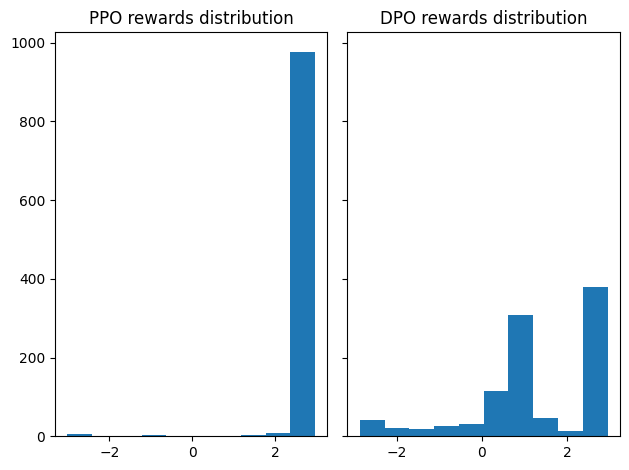

In [38]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(rewards.cpu())
axs[1].hist(rewards_dpo.cpu())
axs[0].title.set_text('PPO rewards distribution')
axs[1].title.set_text('DPO rewards distribution')

Against expectations, DPO has not improved the rewards. See Discussion section.

In case it seems that there is a difference within two distributions, we can calculate Z-test statistics

In [40]:
ztest, propability_value = ztest(rewards.cpu(), rewards_dpo.cpu(), value=torch.mean(rewards).item()-torch.mean(rewards_dpo).item())

In [ ]:
propability_value

If the p-value is less than 0.05, so the difference in the performance of PPO and DPO on this sample is not statistically significant.

###Discussion

Результаты получились обратные ожидаемым..
Вероятно, это связано с тем, что время обучения PPO было значительно дольше, чем DPO, это невыгодная для DPO ситуация (но на большее бесплатных вычислительных ресурсов не хватило бы). Необходимо перепроверить пайплайн исследования и составить больший по объёму датасет для DPO.

####Text diversity comparison

**Entropy**

In [44]:
from scipy.stats import entropy
from collections import defaultdict

def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
      stats[k] /= num_tokens

    return entropy(list(stats.values()))

In [45]:
print('Entropy of texts generated with PPO: ', token_entropy(positive_texts, tokenizer))
print('Entropy of texts generated with DPO: ', token_entropy(dpo_texts, tokenizer))

Entropy of texts generated with PPO:  3.781548071154287
Entropy of texts generated with DPO:  2.274332137307216


The diversity of PPO texts is higher (see comments above)

**Self-BLEU**

The text diversity metric proposed in https://arxiv.org/pdf/1802.01886.pdf

In [51]:
def get_bleu_score(sentence, remaining_sentences):
    lst = []
    for i in remaining_sentences:
        bleu = sentence_bleu(sentence, i)
        lst.append(bleu)
    return lst


def calculate_selfBleu(sentences):
    bleu_scores = []

    for i in sentences:
        sentences_copy = copy.deepcopy(sentences)
        remaining_sentences = sentences_copy.remove(i)
        bleu = get_bleu_score(i,sentences_copy)
        bleu_scores.append(bleu)

    return np.mean(bleu_scores)

In [57]:
print('Self-BLEU of texts generated with PPO: ', calculate_selfBleu(positive_texts[:20]))
print('Self-BLEU of texts generated with DPO: ', calculate_selfBleu(dpo_texts[:20]))

Self-BLEU of texts generated with PPO:  1.0264416299230024e-231
Self-BLEU of texts generated with DPO:  8.220669048329283e-232


The lower the value of the self-bleu score, the higher the diversity in the generated text, so, on this sample, the texts generated with initial policy are more diverse.

###DPO with sigmoid loss

In [73]:
model_sigm = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")
model_ref_sigm = model

training_args = TrainingArguments(output_dir='.', remove_unused_columns=False, max_steps = 500)

dpo_trainer_1 = DPOTrainer(
    model_sigm,
    model_ref_sigm,
    args=training_args,
    beta=0.1,
    train_dataset=dataset,
    tokenizer=tokenizer,
    loss_type = "sigmoid"
)


dpo_trainer_1.train()
dpo_trainer_1.save_model()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
500,202.342800


In [ ]:
dpo_sigm_text_generation = pipeline("text-generation", model=model_sigm, tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb"), device=pipe_device)

dpo_sigm_texts = []
inputs = ds['query'][:1000]

for input in inputs:
  generated_text = dpo_text_generation(input, max_length=50, do_sample=False)[0]
  dpo_sigm_texts.append(generated_text["generated_text"])

In [75]:
dpo_sigm_outputs = sentiment_pipe(dpo_sigm_texts, **sent_kwargs)
rewards_dpo_sigm = torch.tensor([output[1]["score"] for output in dpo_sigm_outputs]).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


####Comparing DPO with *hinge* and *sigmoid* losses

In [84]:
print('Hinge loss mean reward: ', torch.mean(rewards_dpo).item(), '\t Sigmoid loss mean reward: ', torch.mean(rewards_dpo_sigm).item())

Hinge loss mean reward:  1.3077751398086548 	 Sigmoid loss mean reward:  1.3077751398086548


In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(rewards_dpo.cpu())
axs[1].hist(rewards_dpo_sigm.cpu())
axs[0].title.set_text('DPO-hinge rewards distribution')
axs[1].title.set_text('DPO-sigmoid rewards distribution')

In [ ]:
print('Entropy of texts generated with DPO: ', token_entropy(dpo_texts, tokenizer))
print('Entropy of texts generated with DPO-sigm: ', token_entropy(dpo_sigm_texts, tokenizer))

Reviews which are generated with DPO with sigmoid loss are rewarded as more positive and are more diverse.

###**Level 2**

DPOTrainer code: https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L261

To add another loss functions, the function *dpo_loss* should be changed (f-divergences in the paper)

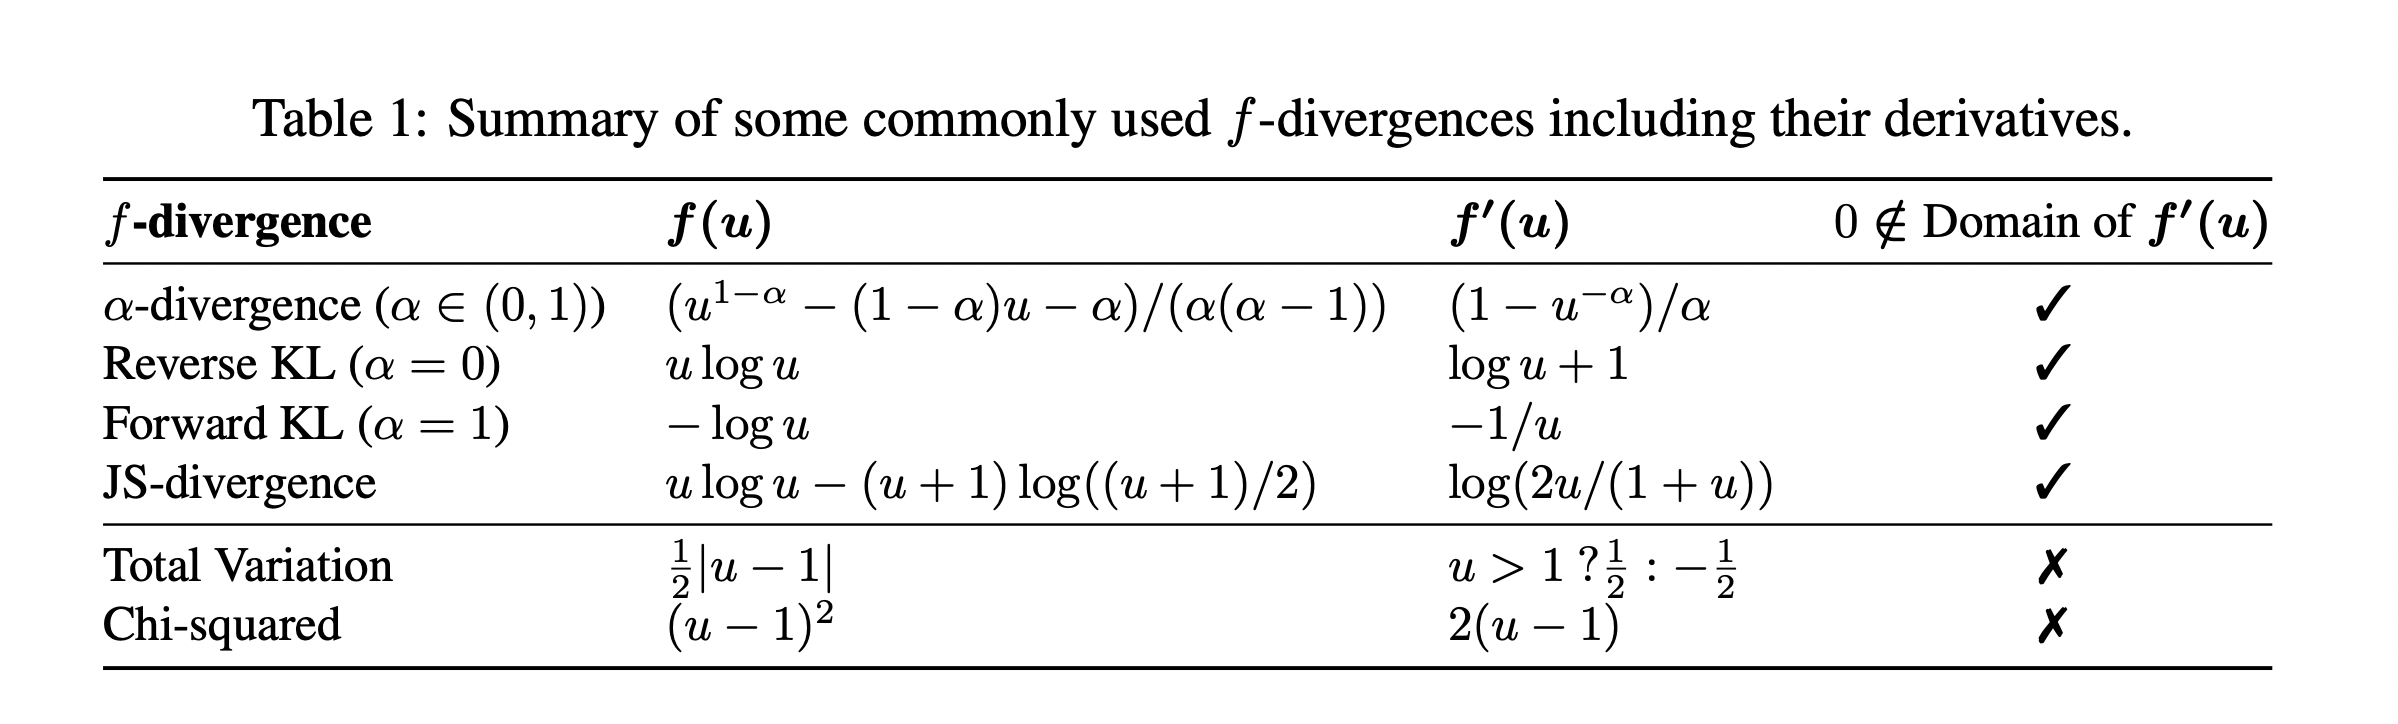

In [ ]:
    def dpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_free: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            policy_chosen_logps: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
            policy_rejected_logps: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
            reference_chosen_logps: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
            reference_rejected_logps: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
            reference_free: If True, we ignore the _provided_ reference model and implicitly use a reference model that assigns equal probability to all responses.

        Returns:
            A tuple of three tensors: (losses, chosen_rewards, rejected_rewards).
            The losses tensor contains the DPO loss for each example in the batch.
            The chosen_rewards and rejected_rewards tensors contain the rewards for the chosen and rejected responses, respectively.
        """
        pi_logratios = policy_chosen_logps - policy_rejected_logps
        if reference_free:
            ref_logratios = 0
        else:
            ref_logratios = reference_chosen_logps - reference_rejected_logps

        logits = pi_logratios - ref_logratios

        # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        # We ignore the reference model as beta -> 0. The label_smoothing parameter encodes our uncertainty about the labels and
        # calculates a conservative DPO loss.
        if self.loss_type == "sigmoid":
            losses = (
                -F.logsigmoid(self.beta * logits) * (1 - self.label_smoothing)
                - F.logsigmoid(-self.beta * logits) * self.label_smoothing
            )
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
        elif self.loss_type == "ipo":
            # eqn (17) of the paper where beta is the regularization parameter for the IPO loss, denoted by tau in the paper.
            losses = (logits - 1 / (2 * self.beta)) ** 2
        elif self.loss_type == "kto":
            # eqn (7) of the HALOs paper
            chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
            rejected_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

            chosen_logratios = policy_chosen_logps - reference_chosen_logps
            rejected_logratios = policy_rejected_logps - reference_rejected_logps
            # As described in the KTO report, the KL term for chosen (rejected) is estimated using the rejected (chosen) half.
            losses = torch.cat(
                (
                    1 - F.sigmoid(self.beta * (chosen_logratios - rejected_KL)),
                    1 - F.sigmoid(self.beta * (chosen_KL - rejected_logratios)),
                ),
                0,
            )

        ##my code
        elif self.loss_type == "fkl":
          u = torch.log((2 * u) / (1 + u))
        elif self.loss_type == "jsd":
          u = -1/u
        elif self.loss_type == "alpha":
          u = (1 - u ** (-divergence)) / divergence
        ...
        ##end of my code
        else:
            raise ValueError(
                f"Unknown loss type: {self.loss_type}. Should be one of ['sigmoid', 'hinge', 'ipo', 'kto']"
            )

        chosen_rewards = self.beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = self.beta * (policy_rejected_logps - reference_rejected_logps).detach()

        return losses, chosen_rewards, rejected_rewards

Простите, что загрузила эту тетрадку на сутки позже дедлайна, хотелось доделать задание до чего-то осмысленного (до дедлайна я не все успела, потому что болела)! Версия на момент дедлайна в репозитории (draft). Спасибо за ваше время в любом случае!